# Objective

We will study the kinematics of the galaxy "ESO113-G032" using integral field spectroscopy (IFS). On one hand, we will create a GIF from the $H\alpha$ images, refining the result as much as possible by modifying the width of the window and the intervals used to process the $H\alpha$ line. On the other hand, we will obtain the rotation curve of the galaxy by using spectra from different points along the major axis of the galaxy, which will allow us to determine the rotation velocity. This curve will be compared with the rotation curve obtained from the mass profile.

# Libraries

We start by importing the Python libraries needed to work with the images; [glob](https://docs.python.org/3/library/glob.html) is used to search for files in a directory, [numpy](https://numpy.org/doc/2.2/user/index.html#user) allows performing numerical calculations, [matplotlib](https://matplotlib.org/stable/users/index.html) is used to [plot graphs](https://matplotlib.org/stable/gallery/), [astropy](https://docs.astropy.org/en/stable/index_user_docs.html) has different modules to work with astronomical images, [photutils](https://photutils.readthedocs.io/en/stable/user_guide/index.html) allows the detection and analysis of sources in astronomical images and [imageio](https://imageio.readthedocs.io/en/stable/) and [IPython](https://ipython.org/) are used to create GIF animations from sequences of images.

In [1]:
import glob
from astropy.io import fits

import numpy as np
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy.modeling import models, fitting


from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry

import os
import imageio.v3 as iio
from IPython.display import Image

#  1.- Data Extraction

We start by reading the data cube information. To do this, we store the cube and display its information so that we can work with it.

In [2]:
cube = fits.open('ESO113-G032.fits')
cube.info()

Filename: ESO113-G032.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1532   ()      
  1  DATA          1 CompImageHDU     75   (408, 327, 3681)   float32   
  2  STAT          1 CompImageHDU     47   (408, 327, 3681)   float32   


# 2.- Header reading - extracting information

We proceed to obtain the information from the data cube. To do this, we display the header and focus on the parameters that interest us.

In [3]:
header = cube[1].header
print(repr(header))

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  408 / length of data axis 1                          
NAXIS2  =                  327 / length of data axis 2                          
NAXIS3  =                 3681 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
ZBLANK  =          -2147483647 / null value in the compressed integer array     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'  

We collect information on the number of dimensions, the dimensions themselves, and the pixel scale and wavelength step information.

The transformation matrix allows the conversion between pixels and real physical magnitudes, meaning it enables the transition from pixels to DEC (degrees), RA (degrees), and wavelength (angstroms). As specified below, this information is contained in CD1_1, CD2_2, and CD3_3, respectively.

In [4]:
dimensions = [header['NAXIS1'], header['NAXIS2'], header['NAXIS3']]
n_dimensions = len(dimensions)


cd11 = header['CD1_1'] # Pixel scale (X)
cd22 = header['CD2_2'] # Pixel scale (Y)
cd33 = header['CD3_3'] # Wavelength step

In [5]:
crpix1 =  header['CRPIX1']
crpix2 =  header['CRPIX2']
crpix3 =  header['CRPIX3']

crval1 = header['CRVAL1']
crval2 = header['CRVAL2']
crval3 = header['CRVAL3']

Next, the data from the data cube is stored in the variable "data", so it can be used in the following sections.

In [6]:
data = cube[1].data

# 3.- Images of the galaxy around the $H\alpha$ line.

We store the wavelengths for further work, for which we perform the conversion to obtain them in angstrom units. Using the relation $\lambda_{obs} = \lambda  (1 + z)$ where $\lambda_{obs}$ is the observed wavelength and $\lambda$ is the theoretical wavelength, we obtain the wavelength of the $H\alpha$ line, taking into account the redshift. We also define the "vector" (list) of integration, which will allow us to obtain images around the $H\alpha$ line. Additionally, we define the reference value of $\lambda_{ref(obs)}$, which is set in accordance with the integration interval.

In [7]:
lambdasA = [cd33 * (i - crpix3) + crval3 for i in range(3681)]

z = 0.029
lambdaHa = 6563 # This is the rest wavelength value of the Hα line. We proceed to obtain the observed value of the Hα line.
lambdaHa_obs = lambdaHa * (1 + z)
lambdaHa_obs_ref = lambdaHa_obs - 100 # This is the reference lambda value that we will use to later add in increments of 20.
integration_interval = np.arange(0, 200, 20)

Taking into account that the integration window has a width of 200 Å, we define two windows at its edges, each with a width of 100 Å, to correct for the continuum. It should be noted that the window where we will perform the integration is centered around the $H\alpha$ wavelength corrected for redshift. We use the previous conversion factor but in reverse to convert from Ångströms to data cube indices. We have proceeded in this way and in this order to be able to define the window width in Ångströms.

In [8]:
edges_window_left = [lambdaHa_obs - 200, lambdaHa_obs - 100]

edges_window_right = [lambdaHa_obs + 100, lambdaHa_obs + 200]

In [9]:
firstindex_window_left = int((edges_window_left[0] - crval3) / cd33 + crpix3)
secondindex_window_left = int((edges_window_left[1] - crval3) / cd33 + crpix3)

firstindex_window_right = int((edges_window_right[0] - crval3) / cd33 + crpix3)
secondindex_window_right = int((edges_window_right[1] - crval3) / cd33 + crpix3)

In [10]:
data_window_left = data[firstindex_window_left:secondindex_window_left, :, :]

data_window_right = data[firstindex_window_right:secondindex_window_right, :, :]

Once we have the data for the windows that we will use to correct the continuum, we integrate, thus obtaining the integrated flux.

In [11]:
flux_window_left = np.nansum(data_window_left, axis=0)
flux_window_right = np.nansum(data_window_right, axis=0)

The objective, as we have discussed, is to correct the continuum. To do this, we need to take the average of the two fluxes obtained, that is, the average between the flux from the left window and the flux from the right window. Additionally, we must take into account the width of the window that we want to correct. In the first case, the window we will integrate over (within the 200 Å window) has a width of 20 Å, so we need to divide the windows that allow us to correct the continuum by 5. This way, both the integration window and the continuum correction window will have the same width, i.e., 20 Å in this case. Then, ``correction_flux,'' as defined below, is the window we use for continuum correction.

In [12]:
flux_window_left_norm = flux_window_left / 5
flux_window_right_norm = flux_window_right / 5

correction_flux = (flux_window_left_norm + flux_window_right_norm) / 2

Next, we proceed to obtain the images. For this, we use the previously defined integration interval and the window that allows us to correct the flux. Additionally, we observe that we use the reference wavelength to properly adjust the integration windows, as mentioned, in accordance with the defined "vector" (list) of integration. We can also note that we again use the conversion to obtain the limits of the integration windows, but now as indices of the data cube, in order to work with them.

Indices: 1523 1539
Image gifHa1_0.png, saved


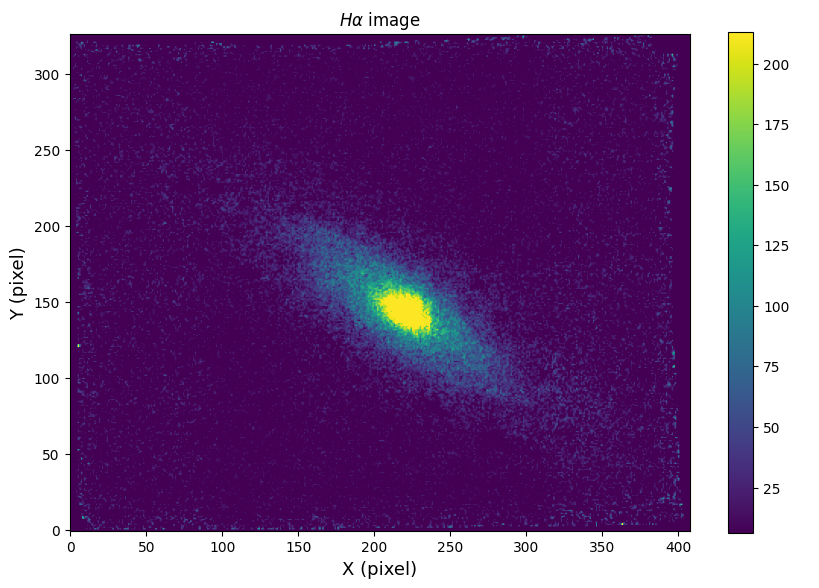

Indices: 1539 1555
Image gifHa1_1.png, saved


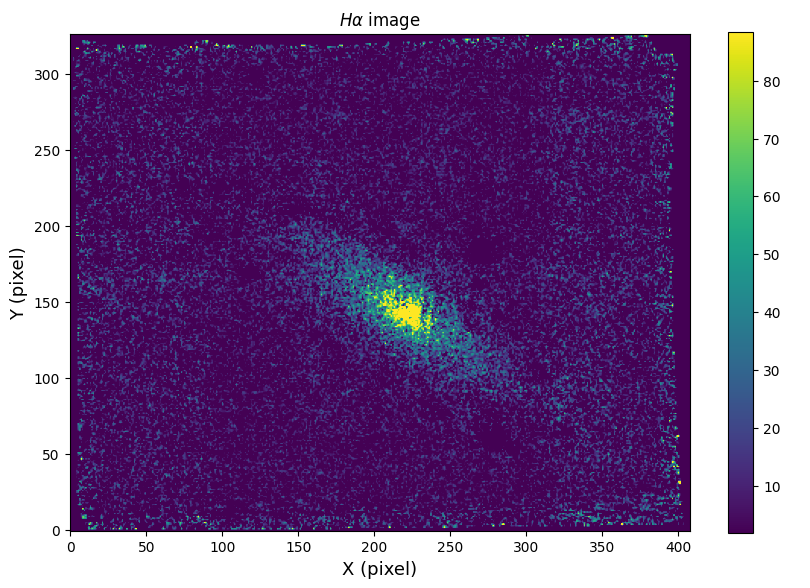

Indices: 1555 1571
Image gifHa1_2.png, saved


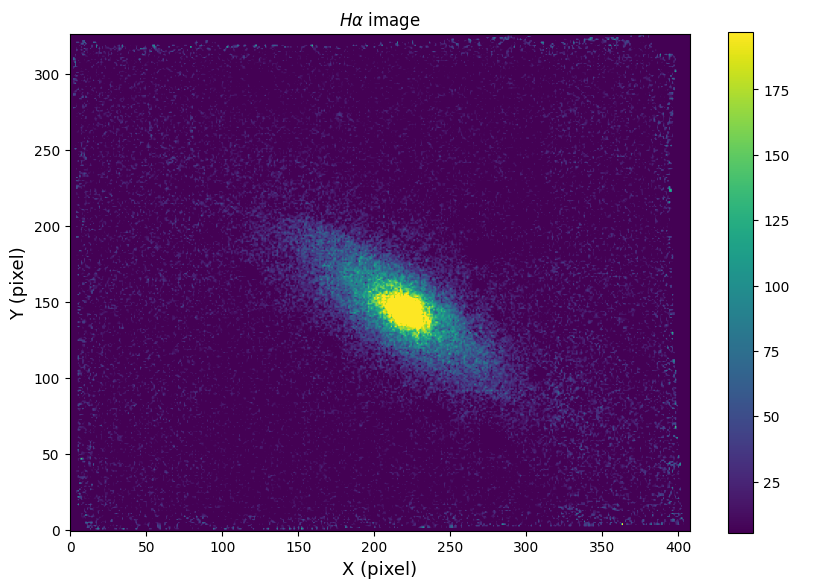

Indices: 1571 1587
Image gifHa1_3.png, saved


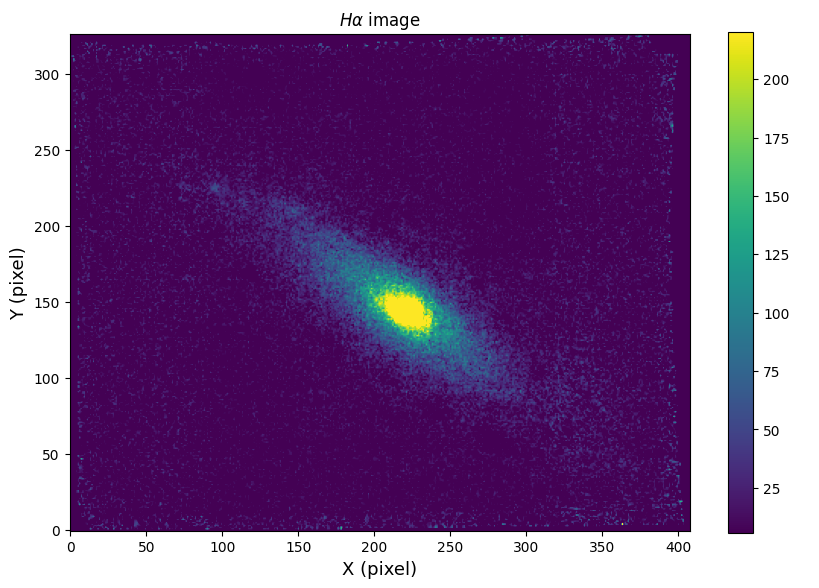

Indices: 1587 1603
Image gifHa1_4.png, saved


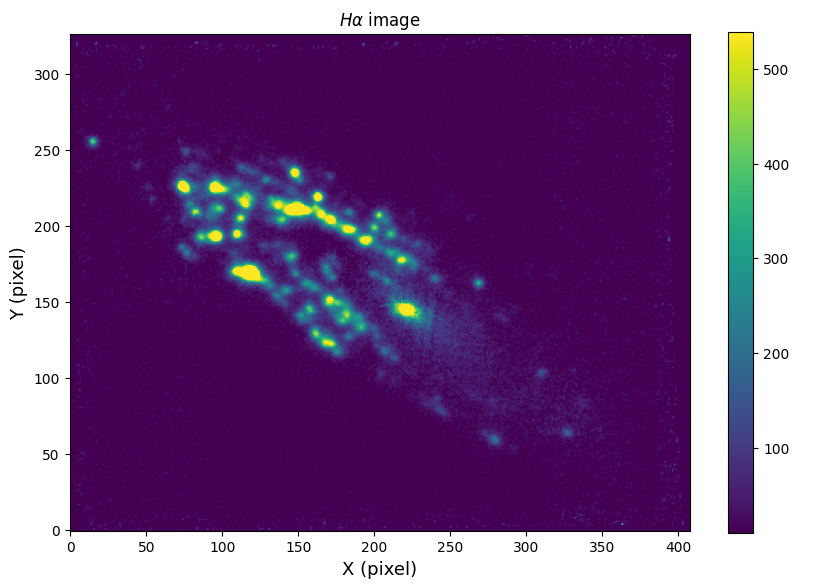

Indices: 1603 1619
Image gifHa1_5.png, saved


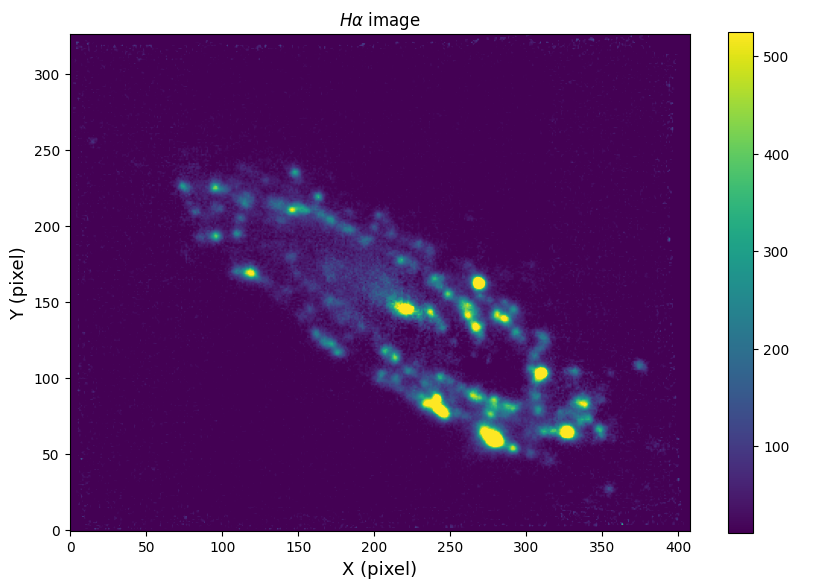

Indices: 1619 1635
Image gifHa1_6.png, saved


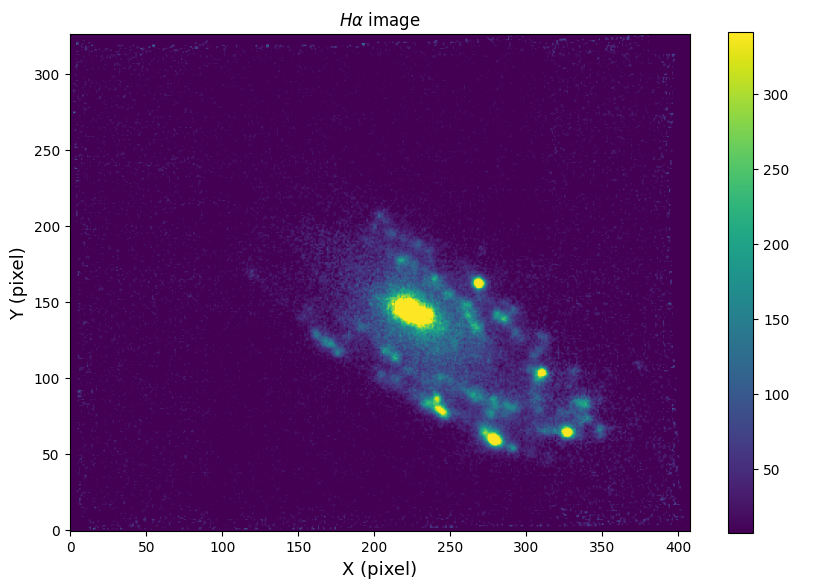

Indices: 1635 1651
Image gifHa1_7.png, saved


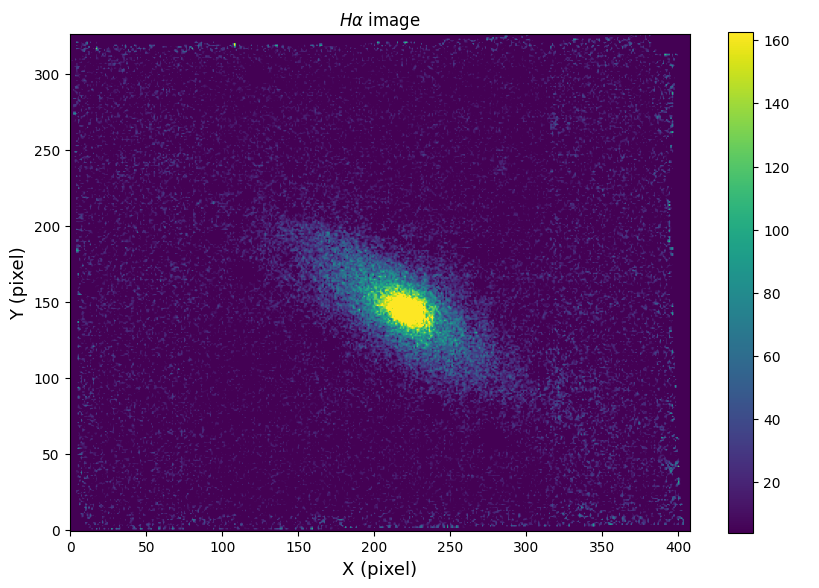

Indices: 1651 1667
Image gifHa1_8.png, saved


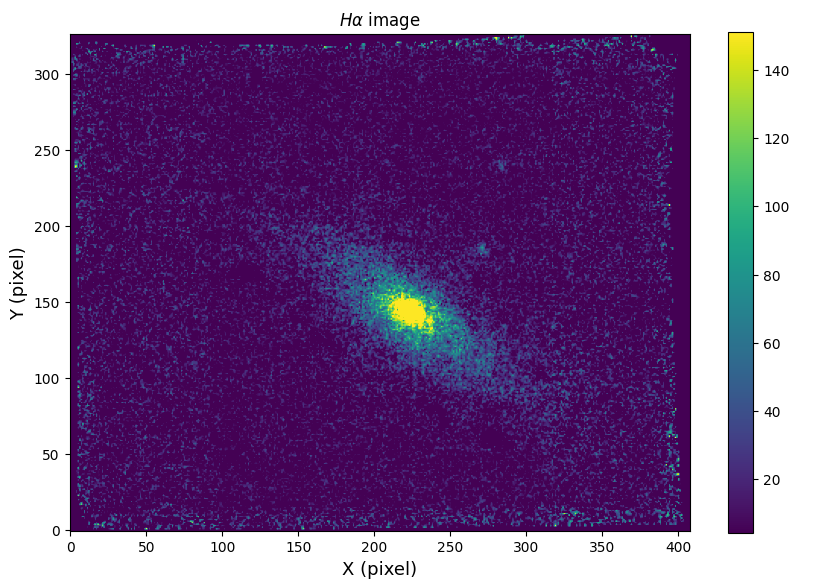

Indices: 1667 1683
Image gifHa1_9.png, saved


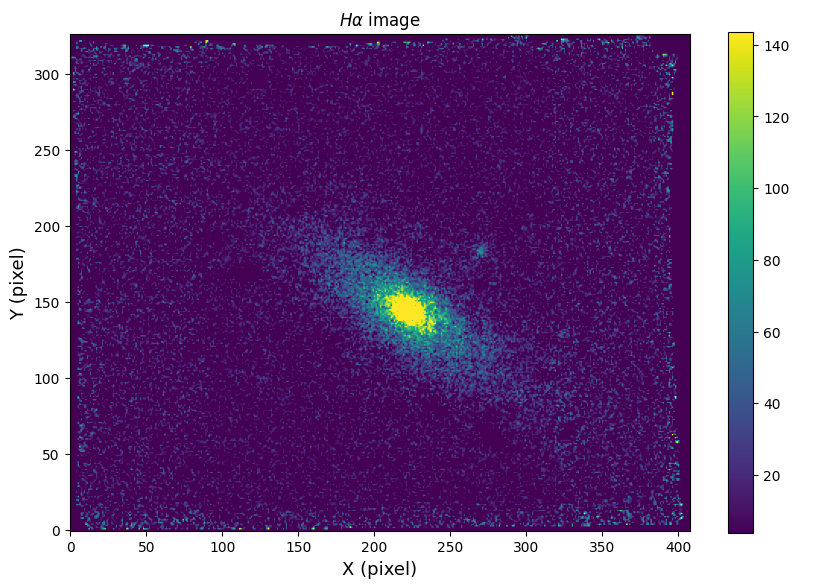

In [16]:
for index, i in enumerate(integration_interval):
    edges_window = [lambdaHa_obs_ref + i, lambdaHa_obs_ref + (i + 20)]

    firstindex_window = int((edges_window[0] - crval3) / cd33 + crpix3)
    secondindex_window = int((edges_window[1] - crval3) / cd33 + crpix3)

    data_window = data[firstindex_window:secondindex_window, :, :]
    
    flux_window = np.nansum(data_window, axis=0)
    flux_corrected = flux_window - correction_flux

    print(f"Indices:", firstindex_window, secondindex_window)

    factor1 = 0.01
    factor2 = 5
    plt.figure("Imagen Ha", figsize=(10, 10))
    
    plt.imshow(
        flux_corrected,
        vmin=np.nanmedian(flux_corrected[50:-50, 50:-50]) - 
        factor1 * np.
        nanstd(flux_corrected[50:-50, 50:-50]), 
        vmax=np.nanmedian(flux_corrected[50:-50, 50:-50]) + 
        factor2 * np.nanstd(flux_corrected[50:-50, 50:-50]), 
        origin="lower"
    )
    
    plt.title(r"$H\alpha$ image")
    plt.xlabel("X (pixel)", fontsize=13)
    plt.ylabel("Y (pixel)", fontsize=13)

    cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
    cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

    
    # plt.savefig(f"gif1/gifHa1_{index}.png")
    print(f"Image gifHa1_{index}.png, saved")
    plt.show()
    plt.close()

As we can see, the HII regions are approximately between pixel 1571 and 1651. We could refine this further, but we establish it this way to ensure that the HII regions are captured within this range. To obtain better images, we create a new window and reduce the integration interval. We could work directly with pixels, but we will proceed analogously to how we just did, and we will work with Ångströms.

In [13]:
lambda1_thin = cd33 * (1571 - crpix3) + crval3
lambda2_thin = cd33 * (1651 - crpix3) + crval3
size_window_lambda = lambda2_thin - lambda1_thin
print(f"This is the size of the window: {size_window_lambda}, we need it to properly normalize when removing the continuum.")

This is the size of the window: 100.0, we need it to properly normalize when removing the continuum.


In [14]:
integration_interval_thin = np.linspace(0, size_window_lambda, 51)
integration_interval_thin

array([  0.,   2.,   4.,   6.,   8.,  10.,  12.,  14.,  16.,  18.,  20.,
        22.,  24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,
        44.,  46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,
        66.,  68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,
        88.,  90.,  92.,  94.,  96.,  98., 100.])

In [15]:
lambda1_thin

6712.310546875

In [16]:
flux_window_left_norm_thin = flux_window_left / 50
flux_window_right_norm_thin = flux_window_right / 50

In [17]:
correction_flux_thin = (flux_window_left_norm_thin + flux_window_right_norm_thin) / 2

In [26]:
for index, i in enumerate(integration_interval_thin):

    edges_window_thin = [lambda1_thin + i, lambda1_thin + (i + 2)]

    firstindex_window_thin = int((edges_window_thin[0] - crval3) / cd33 + crpix3)
    secondindex_window_thin = int((edges_window_thin[1] - crval3) / cd33 + crpix3)

    print(f"Indices:", firstindex_window, secondindex_window)

    data_window_thin = data[firstindex_window_thin:secondindex_window_thin, :, :]

    flux_window_thin = np.nansum(data_window_thin, axis=0)

    flux_corrected_thin = flux_window_thin - correction_flux_thin

    factor1 = 0.01
    factor2 = 5
    plt.figure("Imagen Ha", figsize=(10, 10))
    
    plt.imshow(
        flux_corrected_thin,
        vmin=np.nanmedian(flux_corrected_thin[50:-50, 50:-50]) - 
        factor1 * np.nanstd(flux_corrected_thin[50:-50, 50:-50]), 
        vmax=np.nanmedian(flux_corrected_thin[50:-50, 50:-50]) + 
        factor2 * np.nanstd(flux_corrected_thin[50:-50, 50:-50]), 
        origin="lower"
    )
    
    plt.title(r"$H\alpha$ image")
    plt.xlabel("X (pixel)", fontsize=13)
    plt.ylabel("Y (pixel)", fontsize=13)
    
    cbar = plt.colorbar(label=r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", shrink=0.65)
    cbar.set_label(r"$F_{\lambda}$ ($10^{-20} \, \text{erg/s/cm}^2/\text{Å}$)", fontsize=13)

    # We do not show the images to avoid making it too lengthy.
    # plt.savefig(f"gif2/gifHa2_{index}.png")
    print(f"Image gifHa2_{index}.png, saved")
    # plt.close()

Indices: 1667 1683
Image gifHa2_0.png, saved
Indices: 1667 1683
Image gifHa2_1.png, saved
Indices: 1667 1683
Image gifHa2_2.png, saved
Indices: 1667 1683
Image gifHa2_3.png, saved
Indices: 1667 1683
Image gifHa2_4.png, saved
Indices: 1667 1683
Image gifHa2_5.png, saved
Indices: 1667 1683
Image gifHa2_6.png, saved
Indices: 1667 1683
Image gifHa2_7.png, saved
Indices: 1667 1683
Image gifHa2_8.png, saved
Indices: 1667 1683
Image gifHa2_9.png, saved
Indices: 1667 1683
Image gifHa2_10.png, saved
Indices: 1667 1683
Image gifHa2_11.png, saved
Indices: 1667 1683
Image gifHa2_12.png, saved
Indices: 1667 1683
Image gifHa2_13.png, saved
Indices: 1667 1683
Image gifHa2_14.png, saved
Indices: 1667 1683
Image gifHa2_15.png, saved
Indices: 1667 1683
Image gifHa2_16.png, saved
Indices: 1667 1683
Image gifHa2_17.png, saved
Indices: 1667 1683
Image gifHa2_18.png, saved
Indices: 1667 1683
Image gifHa2_19.png, saved
Indices: 1667 1683
Image gifHa2_20.png, saved
Indices: 1667 1683
Image gifHa2_21.png, save

# 4.- We create a GIF from the previous images.

We create the GIF associated with the first images we saved and display it using IPython. As can be observed, we have not included all the images in the GIF but have only chosen the ones that provide relevant information about the HII regions. The selection of the images was made from the directory.

In [29]:
image_dir = 'gif1' 

# We obtain the paths of the images in the directory where they have been stored.
image_paths = glob.glob(os.path.join(image_dir, "*.png"))

frames = [iio.imread(image_path) for image_path in image_paths]

gif_path = 'gif1/test1gif1.gif'

# We create the GIF using imageio and save it in the directory "gif_path".
iio.imwrite(gif_path, frames, duration=500, loop=0)

print(f"GIF created in {gif_path}")

GIF created in gif1/test1gif1.gif


In [ ]:
gif_path = 'gif1/test1gif1.gif'
Image(gif_path)

![](_static/test1gif1.gif)

Next, we obtain the second GIF, created with the $H\alpha$ images obtained after refining the result.

In [33]:
image_dir = 'gif2'

image_paths = glob.glob(os.path.join(image_dir, "*.png"))

frames = [iio.imread(image_path) for image_path in image_paths]

gif_path = 'gif2/test1gif2.gif'

iio.imwrite(gif_path, frames, duration=500, loop=0)

print(f"GIF created in {gif_path}")

GIF created in gif2/test1gif2.gif


In [1]:
gif_path = 'gif2/test1gif2.gif'
Image(gif_path)

![](_static/test1gif2.gif)

The way the GIF is constructed is consistent with what we see in it, as the first images we have built have a higher redshift because they were the most extreme values on the left side of the window. In other words, they were farther from the wavelength value of $H\alpha$. As we move to the right side of the $H\alpha$ value, the galaxy's blueshift will increase, as we move further away from that value.

# 5.- Deriving the rotation curve of the galaxy.

We can obtain the rotation curve of a spiral galaxy by measuring the radial velocities of various points from the Doppler shift of their spectral lines, considering the geometry of the problem. The observed velocity is given by the following expression $v_{\text{obs}} = v(R) \cdot \cos(\theta) \cdot \sin(i)$ where $i$ is the inclination angle, the angle that the line of sight forms with the disk, and $\theta$ is the angle relative to the major axis of the disk. In our case, $cos\theta = 1$, so solving for it, we obtain the following expression for the radial velocity as a function of the galactocentric radius:

$$
v(R) = \frac{v_{\text{obs}}}{\sin(i)}
$$

Although in the end, we will use the following expression to account for the galaxy's redshift:


$$
\displaystyle v(R) = \left(\frac{\lambda_{obs} - \lambda_{cen}}{\lambda_{cen}} - z_{NED}\right) · c
$$

## 5.1.- We plot the major axis of the galaxy disk over the $H\alpha$ image

Next, we proceed to represent a line along the major axis of the galaxy on an H-alpha image. We perform this step in order to obtain the equation of the line and be able to work with it in the following sections.

In [18]:
z = 0.029
lambdaHa = 6563
lambdaHa_obs = lambdaHa * (1 + z)

lambdasA = np.array(lambdasA)
lambdas_obs = lambdasA * (1 + z)

In [19]:
edges_window_left = [lambdaHa_obs - 150, lambdaHa_obs - 50]
edges_window_Ha = [lambdaHa_obs - 50, lambdaHa_obs + 50]
edges_window_right = [lambdaHa_obs + 50, lambdaHa_obs + 150]

In [20]:
firstindex_window_left = int((edges_window_left[0] - crval3) / cd33 + crpix3)
secondindex_window_left = int((edges_window_left[1] - crval3) / cd33 + crpix3)

firstindex_window_Ha = int((edges_window_Ha[0] - crval3) / cd33 + crpix3)
secondindex_window_Ha = int((edges_window_Ha[1] - crval3) / cd33 + crpix3)

firstindex_window_right = int((edges_window_right[0] - crval3) / cd33 + crpix3)
secondindex_window_right = int((edges_window_right[1] - crval3) / cd33 + crpix3)

print(firstindex_window_left, secondindex_window_left)
print(firstindex_window_Ha, secondindex_window_Ha)
print(firstindex_window_right, secondindex_window_right)

1483 1563
1563 1643
1643 1723


In [21]:
data_window_left = data[firstindex_window_left:secondindex_window_left, :, :]
data_windowHa = data[firstindex_window_Ha:secondindex_window_Ha, :, :]
data_window_right = data[firstindex_window_right:secondindex_window_right, :, :]

In [22]:
flux_window_left = np.nansum(data_window_left, axis=0)
flux_windowHa = np.nansum(data_windowHa, axis=0)
flux_window_right = np.nansum(data_window_right, axis=0)

In [23]:
window_correc = (flux_window_right + flux_window_left) / 2

In [24]:
diff_Ha_window = flux_windowHa - window_correc

We define the line that characterizes the major axis of the galaxy. From part 1, we know that the central point of the galaxy is located at the coordinates (221, 145) in pixels.

In [25]:
x0, y0 = 221, 145  # Central point in image coordinates.
theta = 56  # We calculate the inclination with respect to the y-axis in degrees.

# We calculate the slope with respect to the y-axis.
m = -1 / np.tan(np.radians(theta))

x_vals = np.linspace(0, diff_Ha_window.shape[1] - 10, 500)
y_vals = m * (x_vals - x0) + y0

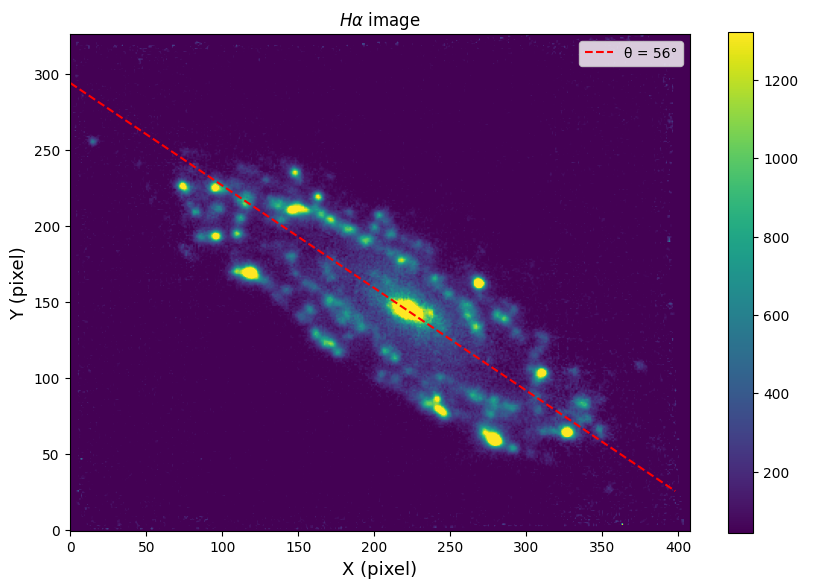

In [26]:
factor1 = 0.01
factor2 = 5

plt.figure("Imagen Ha", figsize=(10, 10))


plt.imshow(
    diff_Ha_window,
    vmin=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor1 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    vmax=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor2 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    origin="lower"
)


# We plot the line over the image.
plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=1.5, label=f'θ = {theta}°')


plt.title(r"$H\alpha$ image")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)
plt.colorbar(label=" ", shrink=0.65)

plt.legend()
plt.show()

## 5.2.- We select a series of points along the major axis on the $H\alpha$ image

In this section, we distribute the points with the sole criterion that they are positioned along the line defined earlier, meaning that the points lie on the galaxy's major axis. Therefore, we consider equidistant points along this line.

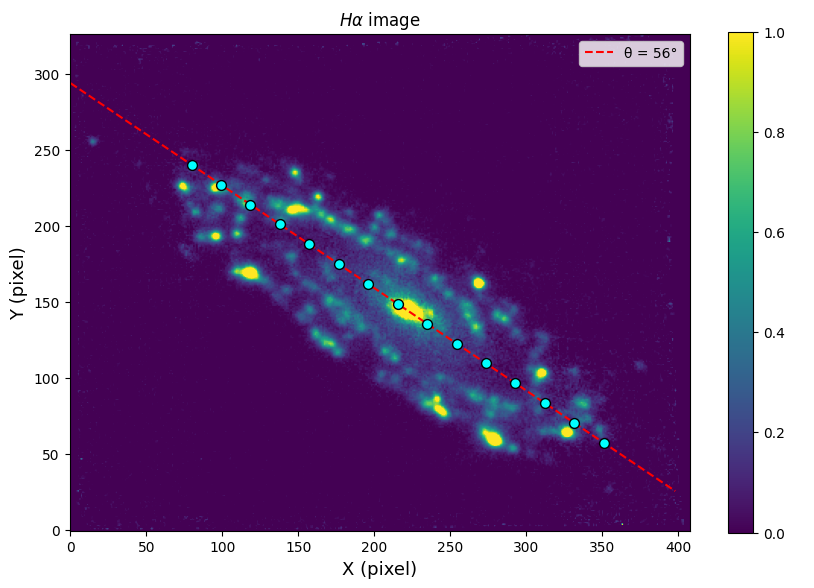

In [27]:
factor1 = 0.01
factor2 = 5

plt.figure("Imagen Ha", figsize=(10, 10))


plt.imshow(
    diff_Ha_window,
    vmin=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor1 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    vmax=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor2 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    origin="lower"
)


x0, y0 = 221, 145
theta = 56

m = -1 / np.tan(np.radians(theta))

x_vals = np.linspace(0, diff_Ha_window.shape[1] - 10, 500)  # Largo de la imagen en X
y_vals = m * (x_vals - x0) + y0  # Ecuación de la recta


plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=1.5, label=f'θ = {theta}°')

# We generate equidistant points along the line.
num_points = 15
x_points = np.linspace(x_vals[100], x_vals[-60], num_points)
y_points = m * (x_points - x0) + y0


plt.scatter(x_points, y_points, color='cyan', edgecolor='black', s=50, zorder=2)


plt.title(r"$H\alpha$ image")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)
plt.colorbar(label=" ", shrink=0.65)

plt.legend()
plt.show()

## 5.3.- We plot the spectra for these points, selecting those that show emission and an $H\alpha$ line.

First, we define the model we will use to fit the emission lines in order to obtain the wavelength. For this, we use a Gaussian for the peak and a polynomial since the continuum is not at 0 height but around 20. We fit the Gaussian around the maximum value of y, that is, around the maximum flux value.

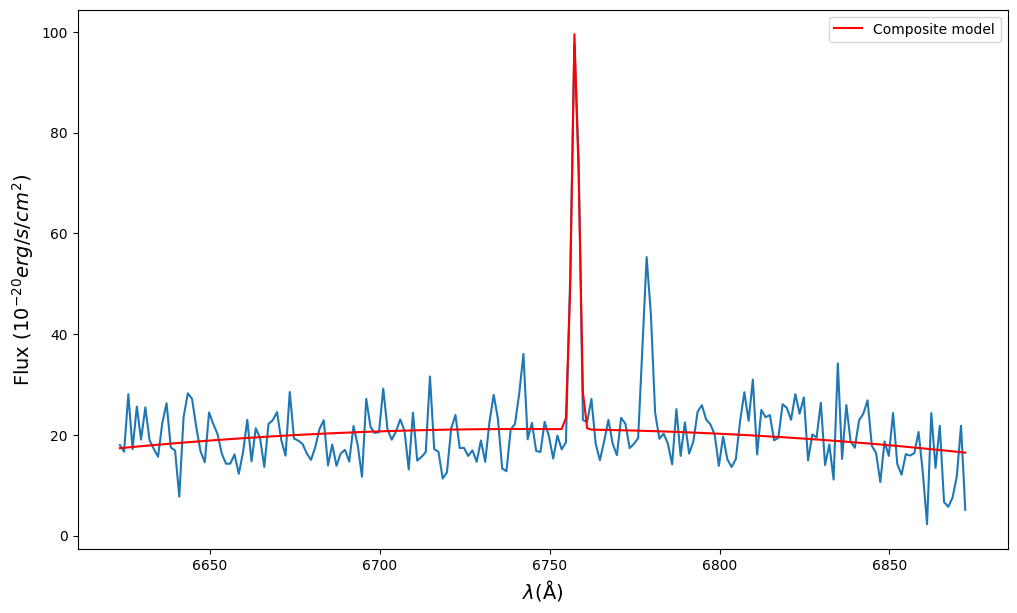

This is the value of the wavelength obtained with the defined model: 6757.563861630443 Å


In [28]:
x = lambdasA[1500:1700]
y = data[:, round(77.67696099619214), round(320.81050990870636)][1500:1700]


# Gaussian model
g_init = models.Gaussian1D(amplitude=np.max(y), mean=x[np.argmax(y)], stddev=1.0)

# Polynomial model
p_init = models.Polynomial1D(degree=2) 

# Composite model, Gaussian + Polynomial
model = g_init + p_init

fit = fitting.TRFLSQFitter()

# We apply the model to the data.
fitted_model = fit(model, x, y)


plt.figure(figsize=(12, 7))
plt.plot(x, y)
plt.plot(x, fitted_model(x), label='Composite model', color='red')  
plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)
plt.legend()  
plt.show()

print(f"This is the value of the wavelength obtained with the defined model: {fitted_model.mean_0.value} Å")

Next, we perform a point selection process. For each group, the resulting spectrum has been analyzed to check if the emission lines were prominent and if the model fit provided correct information. For this, the model has been applied in a generic way, as we will see later. This point selection process has been omitted to avoid making the work too lengthy and to keep it as readable as possible.

In [29]:
num_points = 10
x_points = np.linspace(x_vals[100], x_vals[250], num_points)
y_points = m * (x_points - x0) + y0

x_points_new1 = x_points[[0, 1, 2, 3, 7]]
y_points_new1 = y_points[[0, 1, 2, 3, 7]]

In [30]:
num_points = 10
x_points_new2 = np.linspace(x_vals[250], x_vals[350], num_points)
y_points_new2 = m * (x_points_new2 - x0) + y0

x_points_new3 = np.delete(x_points_new2, [0, 1, 7, 8, 9])
y_points_new3 = np.delete(y_points_new2, [0, 1, 7, 8, 9])

In [31]:
num_points = 10
x_points_new4 = np.linspace(x_vals[250], x_vals[-60], num_points)
y_points_new4 = m * (x_points_new4 - x0) + y0

x_points_new5 = x_points_new4[[6, 7, 8]]
y_points_new5 = y_points_new4[[6, 7, 8]]

We take more points, especially selecting those from the center of the galaxy to properly fit the rotation curve, as we will see later.

In [32]:
x_points_finals = []
y_points_finals = []

x_points_finals.append(x_points_new1)
x_points_finals.append(x_points_new3)
x_points_finals.append(x_points_new5)

y_points_finals.append(y_points_new1)
y_points_finals.append(y_points_new3)
y_points_finals.append(y_points_new5)

x_points_finals = np.concatenate(x_points_finals)
y_points_finals = np.concatenate(y_points_finals)

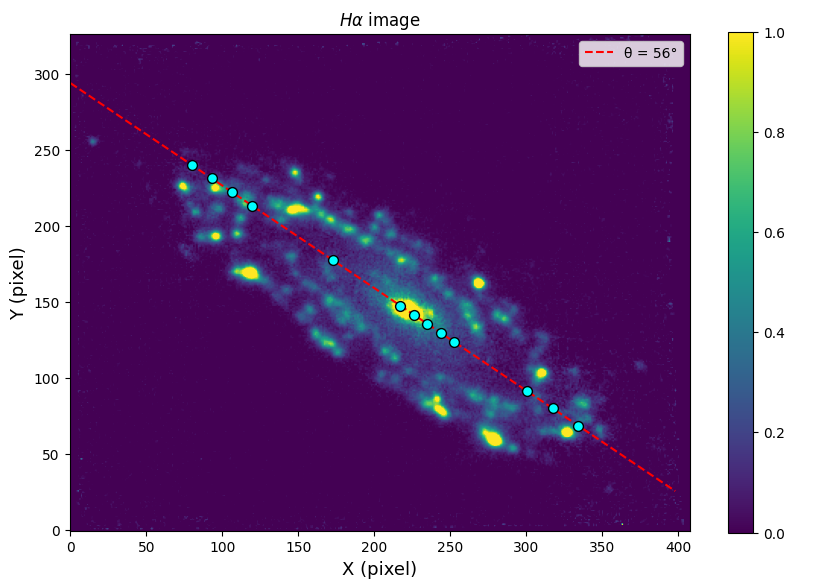

In [33]:
factor1 = 0.01
factor2 = 5

plt.figure("Imagen Ha", figsize=(10, 10))

plt.imshow(
    diff_Ha_window,
    vmin=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor1 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    vmax=np.nanmedian(diff_Ha_window[50:-50, 50:-50]) + 
    factor2 * np.nanstd(diff_Ha_window[50:-50, 50:-50]), 
    origin="lower"
)

plt.plot(x_vals, y_vals, color='red', linestyle='--', linewidth=1.5, label=f'θ = {theta}°')

plt.scatter(x_points_finals, y_points_finals, color='cyan', edgecolor='black', s=50, zorder=2)

plt.title(r"$H\alpha$ image")
plt.xlabel("X (pixel)", fontsize=13)
plt.ylabel("Y (pixel)", fontsize=13)
plt.colorbar(label=" ", shrink=0.65)

plt.legend()
plt.show()

We calculate the galactocentric distance of each point.

In [34]:
x_points_finals_deg = cd11 * (x_points_finals - crpix1) + crval1
y_points_finals_deg = cd22 * (x_points_finals - crpix2) + crval2
x0_deg = cd11 * (x0 - crpix1) + crval1
y0_deg = cd22 * (y0 - crpix2) + crval2

d_pix = np.sqrt((x_points_finals - x0)**2 + (y_points_finals - y0)**2)
d_arc = np.sqrt((x_points_finals_deg - x0_deg)**2 + (y_points_finals_deg - y0_deg)**2)
d_pc = 1 / d_arc
print(d_pc)

[115.69596767 130.34922683 148.76712006 172.27316269 323.52032626
 249.21339474 221.84261979 198.00170049 177.71054257 160.5577365
 103.12444148  91.21377898  81.68942461]


Now we represent the spectra of each of the points and store the obtained wavelength from each of them in a list, so that we can work with them. As we can observe, the spectral lines that have been selected are both $H\alpha$ and $NII$.

79.75951903807615 240.26790733173826
6746.890018809654


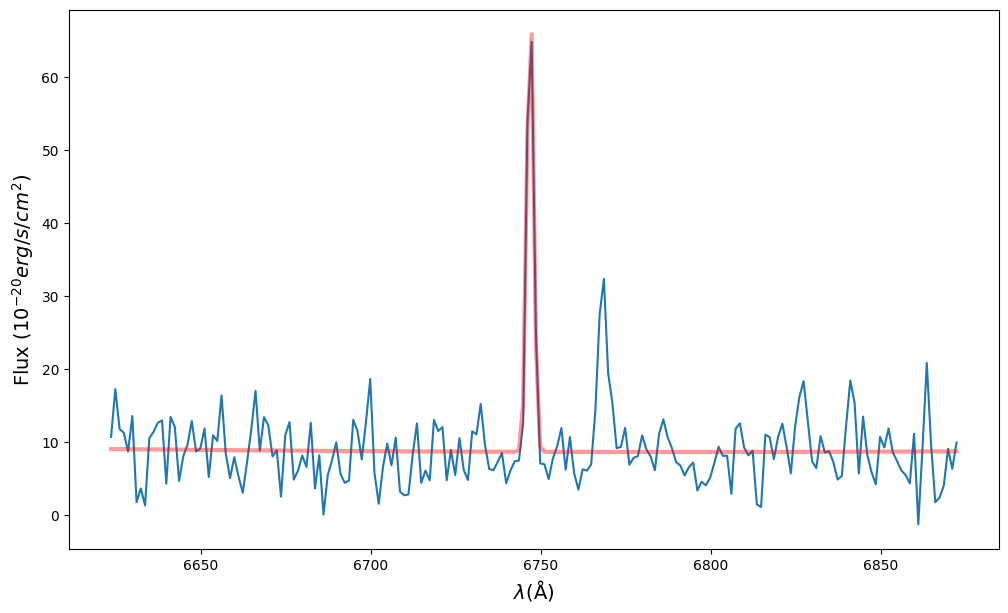

93.05277221108884 231.30149484999856
6746.641579211768


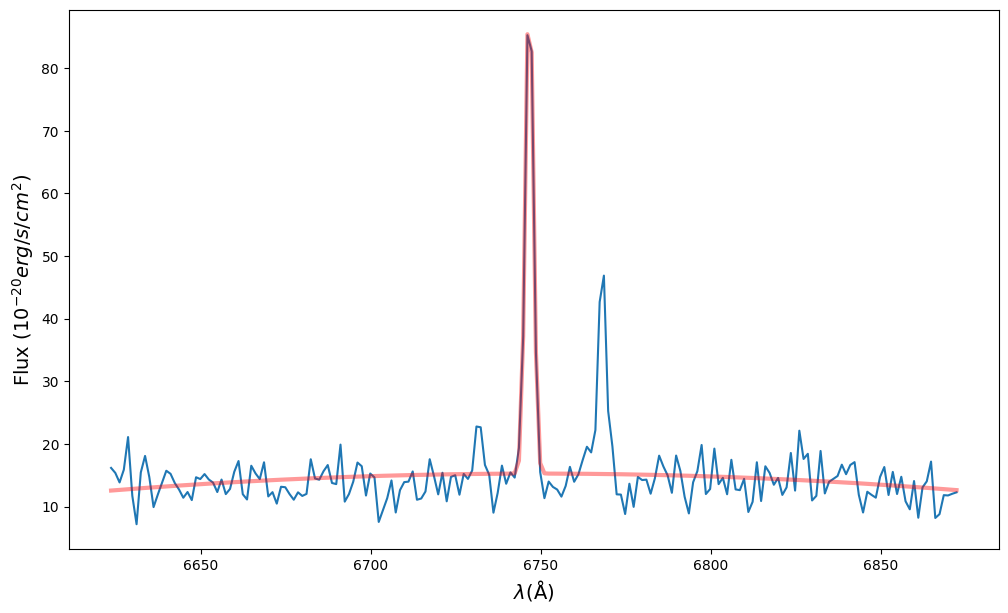

106.34602538410154 222.3350823682589
6746.577212938224


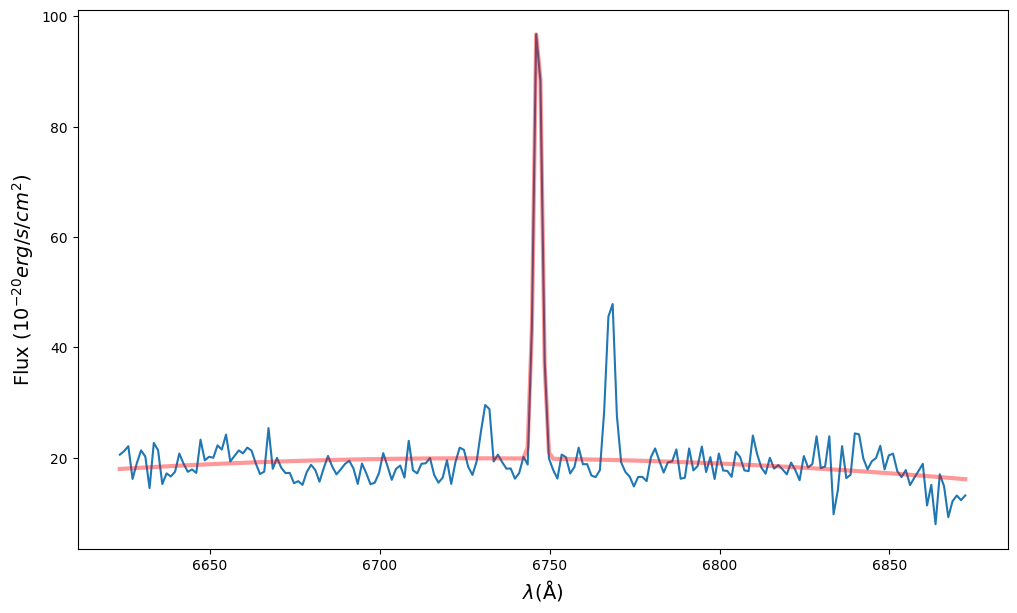

119.63927855711424 213.36866988651923
6746.709222590611


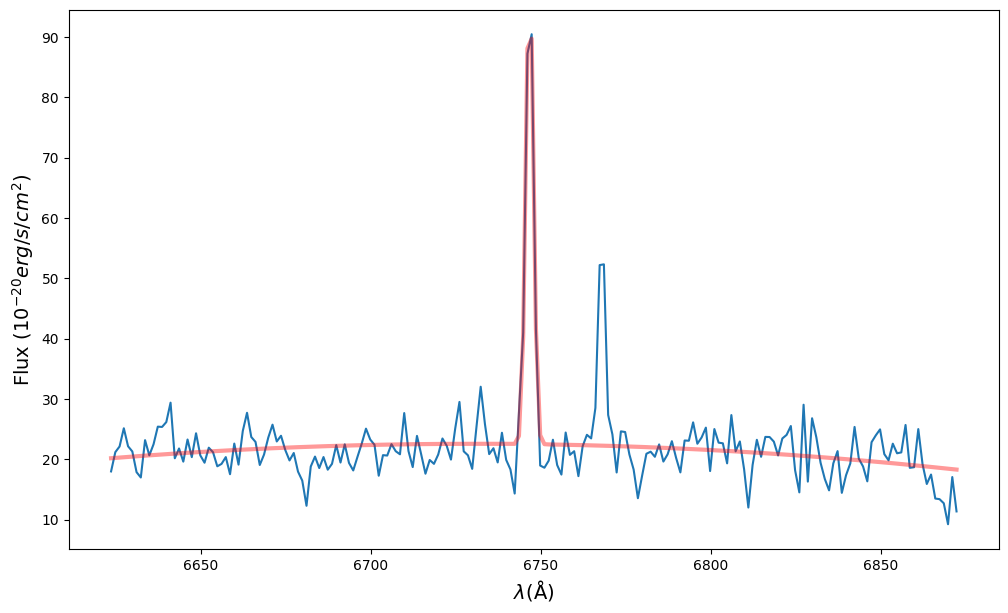

172.812291249165 177.50301995956053
6746.6703129099515


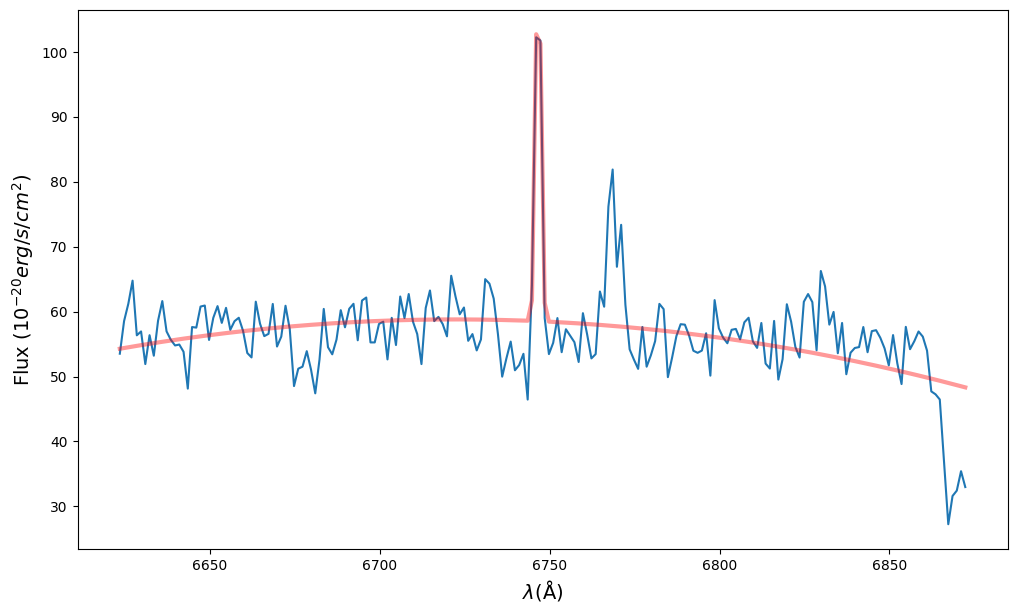

217.12313515920732 147.61497835376161
6771.359588388135


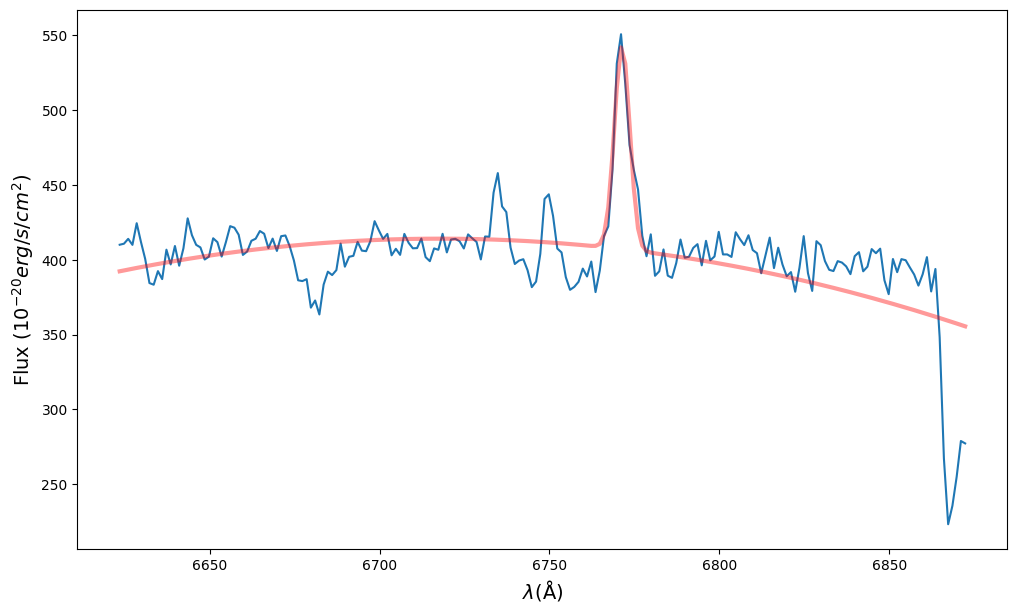

225.9853039412158 141.63737003260184
6775.320801118228


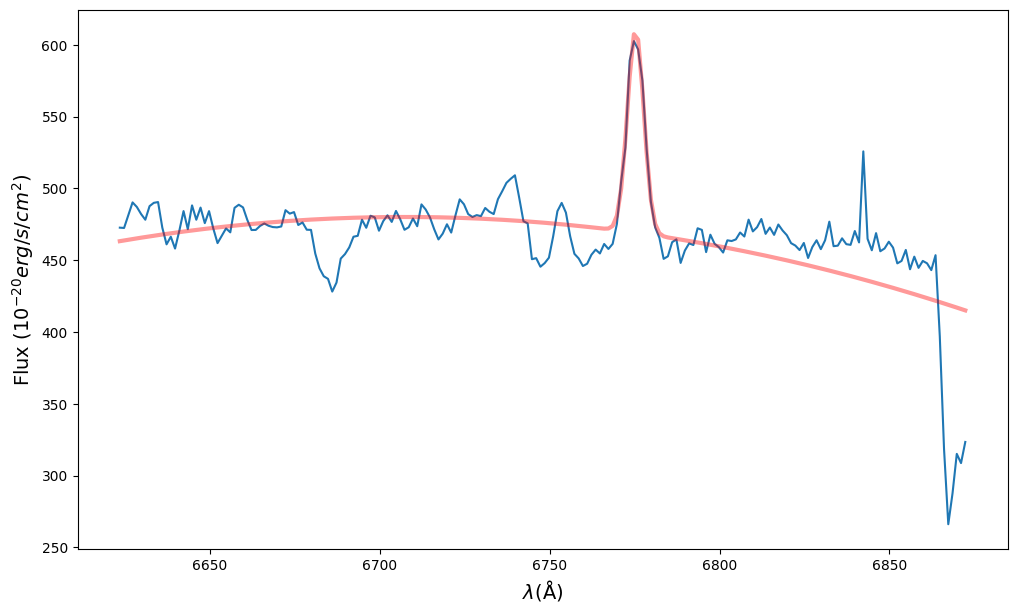

234.84747272322426 135.65976171144206
6776.170178330312


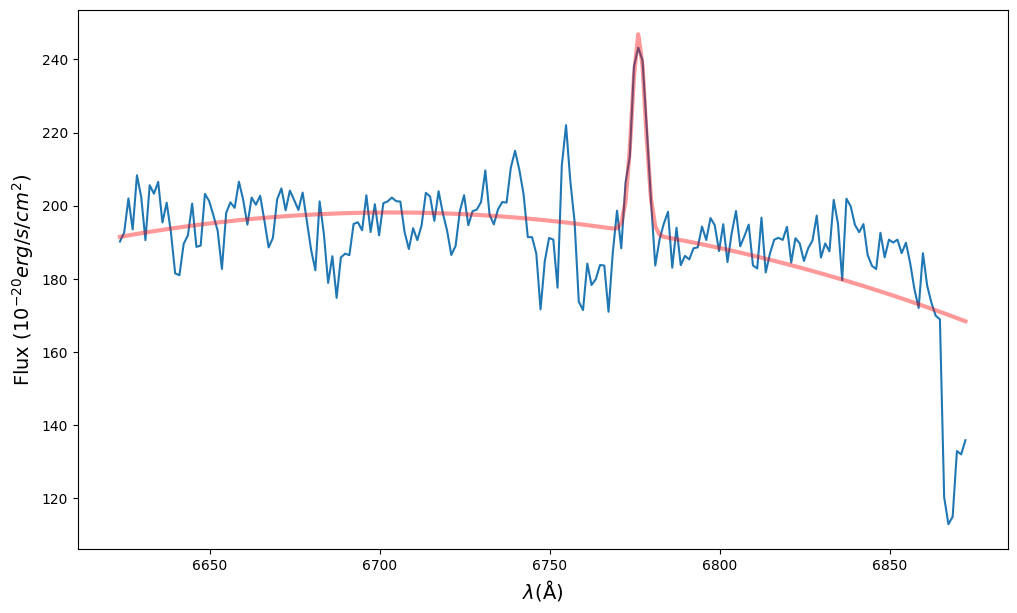

243.7096415052327 129.68215339028228
6777.117394645696


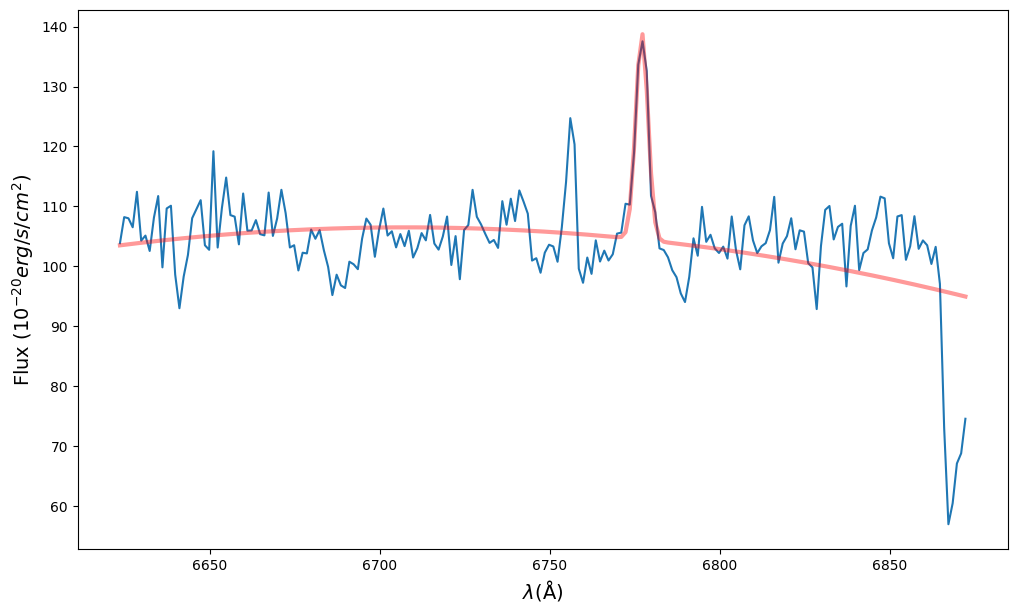

252.57181028724116 123.7045450691225
6778.209694045511


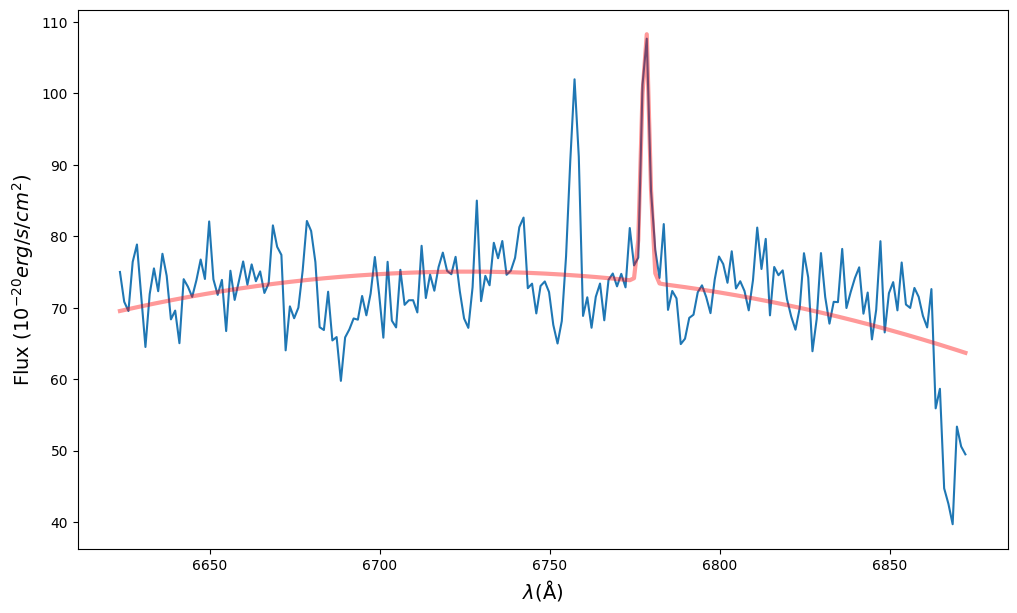

300.42752171008686 91.42546013485966
6757.383360583399


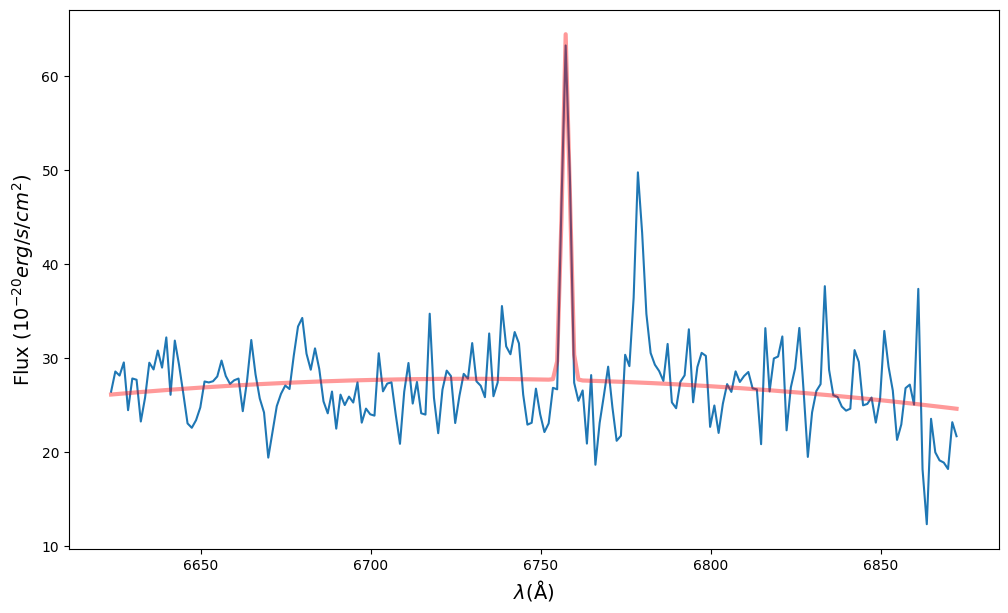

317.26564239590294 80.06800432465609
6757.318830343095


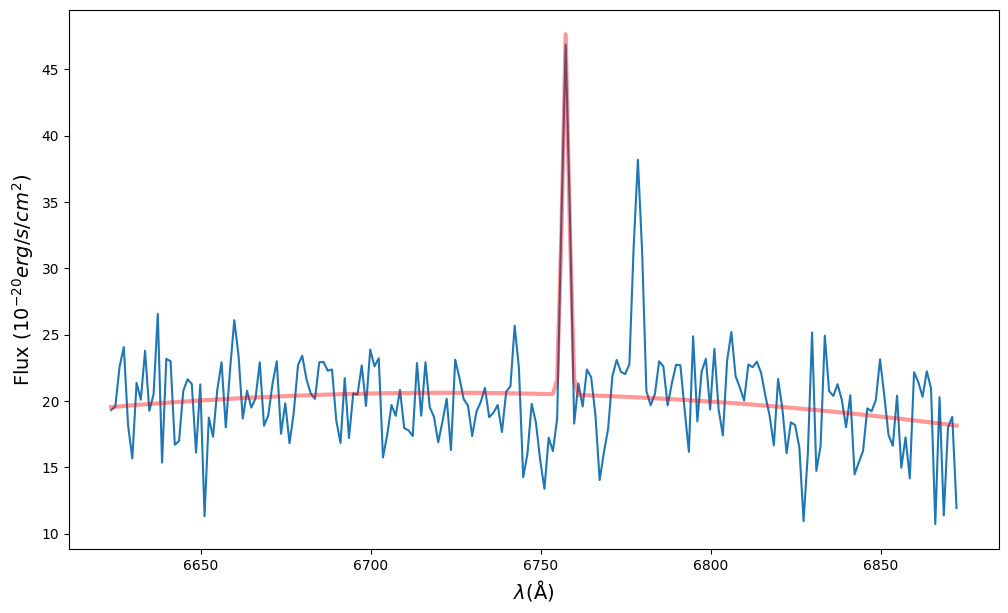

334.103763081719 68.7105485144525
6757.884375361391


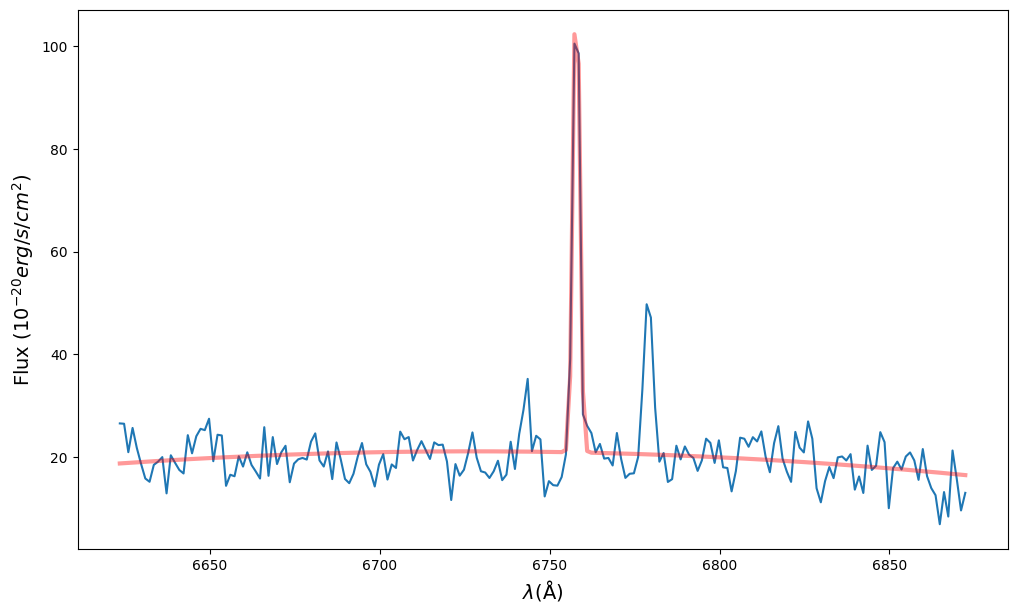

In [35]:
lambdas_med = []
for x_poin, y_poin in zip(x_points_finals, y_points_finals):
    plt.figure("Image 5.3.2", figsize=(12, 7))

    x = lambdasA[1500:1700]
    y = data[:, int(np.round(y_poin)), int(np.round(x_poin))][1500:1700]
    print(x_poin, y_poin)
    
    # Gaussian model
    g_init = models.Gaussian1D(amplitude=np.max(y), mean=x[np.argmax(y)], stddev=1.0)
    
    # Polynomial model
    p_init = models.Polynomial1D(degree=2) 
    
    # Composite model, Gaussian + Polynomial
    model = g_init + p_init
    
    # Fitter
    fit = fitting.TRFLSQFitter()

    
    plt.plot(x, y)

    fitted_model = fit(model, x, y)
    
    lambdas_med = np.append(lambdas_med, fitted_model.mean_0.value)

    print(fitted_model.mean_0.value)
    
    plt.plot(x, fitted_model(x), label='Composite model', color='red', linewidth=3, alpha=0.4)  
    

    plt.title(f"") 
    plt.ylabel("Flux ($10^{-20}erg/s/cm^2$)", fontsize=14)
    plt.xlabel("$\lambda (\mathrm{\AA})$", fontsize=14)
    
    plt.show()

## 5.4.a.- We calculate the rotation curve from the measured lines and the galactocentric distances.

We make use of the following expression $\displaystyle \frac{\lambda_{obs} - \lambda_{cen}}{\lambda_{cen}} = z = \frac{v}{c}$, so we have that the observed velocity is given by the following expression: $\displaystyle v_{obs} = \frac{\lambda_{obs} - \lambda_{cen}}{\lambda_{cen}} · c$. Now, we consider the expression of $v(R)$ that we mentioned earlier, which is the expression of the velocity we need to calculate to represent the rotation curve. This is the following expression:

$$
\displaystyle v(R) = \frac{v_{obs}}{sin \, i}
$$

We will work with the H-alpha line and the NII line. Below, we collect the values of the rest wavelengths 
($\lambda_{cen}$) to apply the previous expression.

We are actually using the following expression to account for the redshift correction:


$$
\displaystyle v(R) = \left(\frac{\lambda_{obs} - \lambda_{cen}}{\lambda_{cen}} - z_{NED}\right) · c
$$

In [147]:
lambdaHa = 6563
lambdaNII = 6584
i = 71
c = 3e5 # km/s

We need to discern in the total list of points which ones are being worked with the H-alpha line and which with the NII lines.

In [148]:
x_points_finals_Ha = x_points_finals[[0, 1, 2, 3, 4, 10, 11, 12]]
y_points_finals_Ha = y_points_finals[[0, 1, 2, 3, 4, 10, 11, 12]]

x_points_finals_NII = x_points_finals[[5, 6, 7, 8, 9]]
y_points_finals_NII = y_points_finals[[5, 6, 7, 8, 9]]

In [149]:
x_points_finals_Ha_deg = cd11 * (x_points_finals_Ha - crpix1) + crval1
y_points_finals_Ha_deg = cd22 * (y_points_finals_Ha - crpix2) + crval2

d_arc_Ha = np.sqrt((x_points_finals_Ha_deg - x0_deg)**2 + (y_points_finals_Ha_deg - y0_deg)**2)

In [150]:
x_points_finals_NII_deg = cd11 * (x_points_finals_NII - crpix1) + crval1
y_points_finals_NII_deg = cd22 * (y_points_finals_NII - crpix2) + crval2

d_arc_NII = np.sqrt((x_points_finals_NII_deg - x0_deg)**2 + (y_points_finals_NII_deg - y0_deg)**2)

In [151]:
# We calculate the distance to the galaxy in Mpc.
H0 = 70  # km/s/Mpc
D_Mpc = (z * 3e5) / H0
print(f"The distance to the galaxy calculated from the NED redshift is {D_Mpc:.2f} Mpc, while the distance obtained directly from NED is: (126.60 ± 8.96) Mpc.")
D_pc = D_Mpc * 1000

The distance to the galaxy calculated from the NED redshift is 124.29 Mpc, while the distance obtained directly from NED is: (126.60 ± 8.96) Mpc.


We will work with the distance calculated from the redshift, that is, 124.29 Mpc.

In [152]:
d_rad_Ha = np.radians(d_arc_Ha)
d_pc_Ha = D_pc * np.tan(d_rad_Ha)

d_pc_Ha_corr = d_pc_Ha / np.sin(np.radians(i))
print(f"These are the galactocentric radii associated with the $H\alpha$ line data points:", d_pc_Ha_corr)

These are the galactocentric radii associated with the $Hlpha$ line data points: [21.71405772 19.67037683 17.62669596 15.58301509  7.40829169 12.21104437
 14.79970679 17.38836922]


In [153]:
d_rad_NII = np.radians(d_arc_NII)
d_pc_NII = D_pc * np.tan(d_rad_NII)

d_pc_NII_corr = d_pc_NII / np.sin(np.radians(i))
print(f"These are the galactocentric radii associated with the $NII$ line data points:", d_pc_Ha_corr)

These are the galactocentric radii associated with the $NII$ line data points: [21.71405772 19.67037683 17.62669596 15.58301509  7.40829169 12.21104437
 14.79970679 17.38836922]


Similarly, we must distinguish between the wavelength values corresponding to $H\alpha$ and $NII$.

In [157]:
lambdas_Ha_med = lambdas_med[[0, 1, 2, 3, 4, 10, 11, 12]]
lambdas_NII_med = lambdas_med[[5, 6, 7, 8, 9]]

In [158]:
des_Ha = ((lambdas_Ha_med - lambdaHa) / lambdaHa)
des_NII = ((lambdas_NII_med - lambdaNII) / lambdaNII)

In [159]:
desHa_dif = np.abs(des_Ha - z)
des_NII_dif = np.abs(des_NII - z)

In [160]:
vR_Ha = desHa_dif * c
vR_NII = des_NII_dif * c

In [161]:
vRtotal = []
vRtotal.append(vR_Ha)
vRtotal.append(vR_NII)
print(vRtotal)
vRtotal = np.concatenate(vRtotal)

R = []
R.append(d_pc_Ha_corr)
R.append(d_pc_NII_corr)
print(R)
R = np.concatenate(R)

[array([294.23957902, 305.59595253, 308.53818658, 302.50391937,
       304.28251212, 185.41949947, 182.46977037, 208.32128728]), array([162.95921682,  17.53346529,  56.23534312,  99.39526028,
       149.16588907])]
[array([21.71405772, 19.67037683, 17.62669596, 15.58301509,  7.40829169,
       12.21104437, 14.79970679, 17.38836922]), array([0.59602223, 0.76643166, 2.12888555, 3.49133944, 4.85379333])]


## 5.4.b.- We now represent the rotation curve calculated from the emission lines.

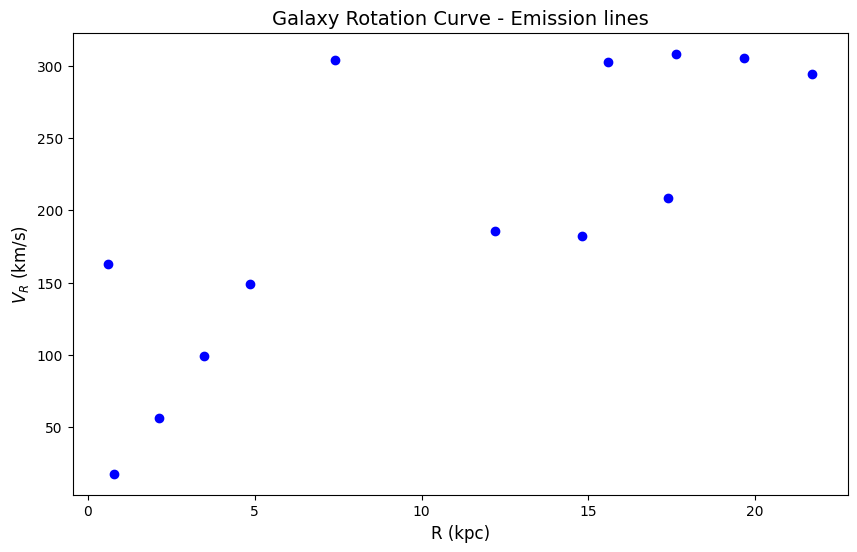

In [162]:
plt.figure("Galaxy Rotation Curve - Emission lines", figsize=(10, 6))

plt.scatter(R, vRtotal, color='blue')


plt.xlabel('R (kpc)', fontsize=12)
plt.ylabel('$V_R$ (km/s)', fontsize=12)

plt.title('Galaxy Rotation Curve - Emission lines', fontsize=14)
plt.show()

We observe some anomalous data points, which we remove in order to obtain a rotation curve that makes physical sense. These points may be incorrect due to the redshift values used, which depend on the specific region of the galaxy being observed.

In [163]:
vRtotal_cor = vRtotal[[0, 1, 2, 3, 4, 9, 10, 11, 12]]
R_cor = R[[0, 1, 2, 3, 4, 9, 10, 11, 12]]

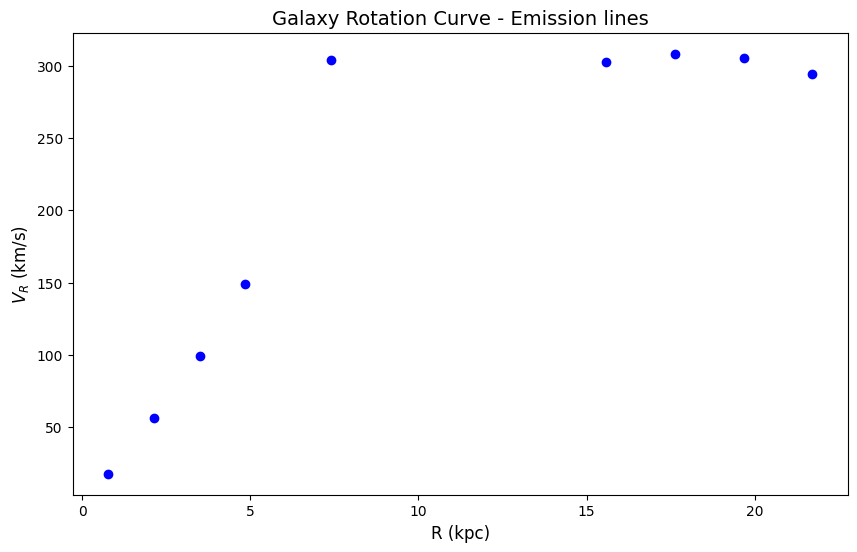

In [164]:
plt.figure("Galaxy Rotation Curve - Emission lines", figsize=(10, 6))

plt.scatter(R_cor, vRtotal_cor, color='blue')


plt.xlabel('R (kpc)', fontsize=12)
plt.ylabel('$V_R$ (km/s)', fontsize=12)

plt.title('Galaxy Rotation Curve - Emission lines', fontsize=14)
plt.show()

Next, we perform a polynomial fit on the selected points. The fit may not be as expected since we have removed points that we previously relied on to represent the graph.

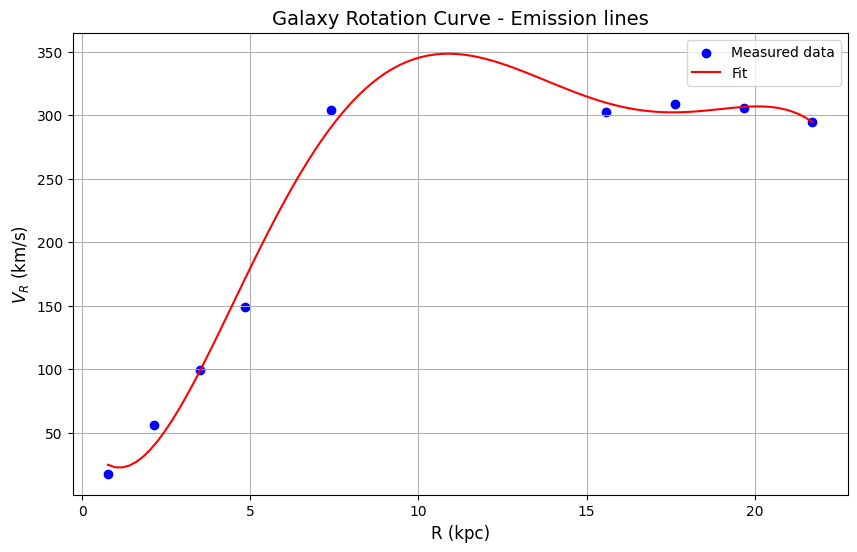

In [165]:
plt.figure("Galaxy Rotation Curve - Emission lines", figsize=(10, 6))


degree = 5
coefficients = np.polyfit(R_cor, vRtotal_cor, degree)
poly = np.poly1d(coefficients)

R_fit = np.linspace(min(R_cor), max(R_cor), 100)
vR_fit = poly(R_fit)  

plt.scatter(R_cor, vRtotal_cor, color='blue', label='Measured data')

plt.plot(R_fit, vR_fit, 'r-', label=f'Fit')

plt.xlabel('R (kpc)', fontsize=12)
plt.ylabel('$V_R$ (km/s)', fontsize=12)
plt.title('Galaxy Rotation Curve - Emission lines', fontsize=14)

plt.legend()
plt.grid(True)

plt.show()

## 5.5.- We derive the rotation curve from the mass profile information.

In [166]:
dist_km, mass_kg = np.loadtxt('perfil_masa.txt', unpack=True, delimiter=',')

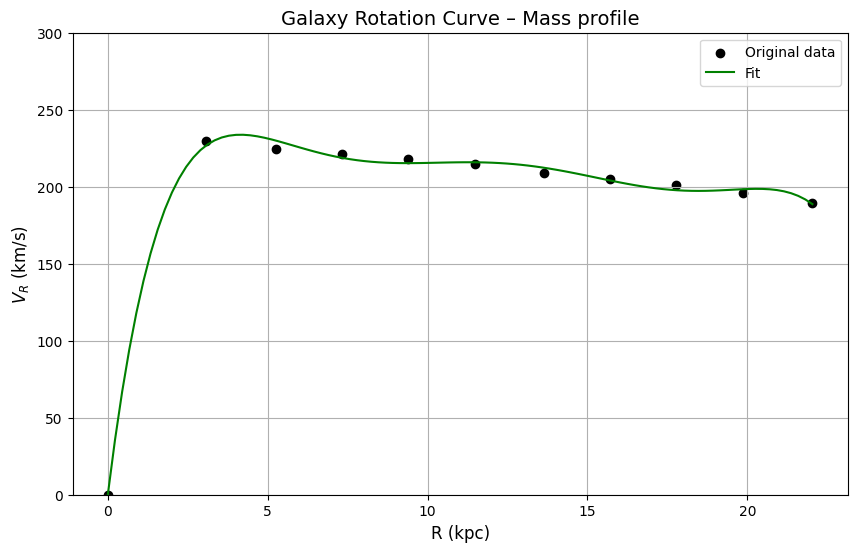

In [173]:
plt.figure("Galaxy Rotation Curve – Mass profile", figsize=(10, 6))

# Universal gravitational constant
G = 6.67430e-20  # km^3/kg/s^2

dist_kpc = dist_km / 3.086e16

# We calculate the rotational velocity using Newton's law of gravitation formula.
v_rot = np.sqrt(G * mass_kg / dist_km)


# We plot the original data.
plt.scatter(dist_kpc, v_rot, color='black', label='Original data')

# Polynomial fit
degree = 6
coefficients = np.polyfit(dist_kpc, v_rot, degree)
poly = np.poly1d(coefficients)

dist_kpc_fit = np.linspace(min(dist_kpc), max(dist_kpc), 100)
v_rot_fit = poly(dist_kpc_fit)


# We plot the fitted curve
plt.plot(dist_kpc_fit, v_rot_fit, 'g-', label=f'Fit')

plt.xlabel('R (kpc)', fontsize=12)
plt.ylabel('$V_R$ (km/s)', fontsize=12)
plt.ylim(0, 300)
plt.title('Galaxy Rotation Curve – Mass profile', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

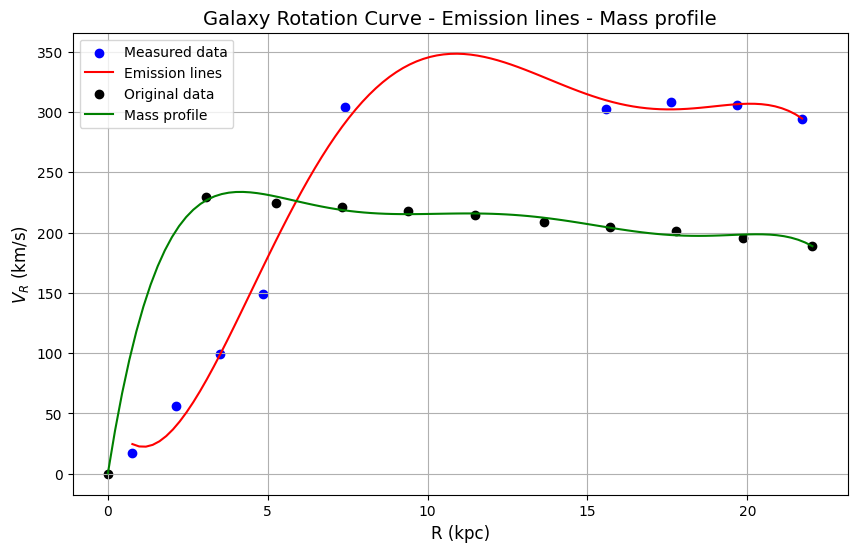

In [176]:
plt.figure("Galaxy Rotation Curve - Emission lines - Mass profile", figsize=(10, 6))

# Polynomial fit - Emission lines
degree = 5
coefficients = np.polyfit(R_cor, vRtotal_cor, degree)
poly = np.poly1d(coefficients)

R_fit = np.linspace(min(R_cor), max(R_cor), 100)
vR_fit = poly(R_fit)  

plt.scatter(R_cor, vRtotal_cor, color='blue', label='Measured data')

plt.plot(R_fit, vR_fit, 'r-', label=f'Emission lines')

# Universal gravitational constant
G = 6.67430e-20  # km^3/kg/s^2

dist_kpc = dist_km / 3.086e16

# We calculate the rotational velocity using Newton's law of gravitation formula.
v_rot = np.sqrt(G * mass_kg / dist_km)

# We plot the original data.
plt.scatter(dist_kpc, v_rot, color='black', label='Original data')

# Polynomial fit - Mass profile
degree = 6
coefficients = np.polyfit(dist_kpc, v_rot, degree)
poly = np.poly1d(coefficients)

dist_kpc_fit = np.linspace(min(dist_kpc), max(dist_kpc), 100)
v_rot_fit = poly(dist_kpc_fit)

# We plot the fitted curve
plt.plot(dist_kpc_fit, v_rot_fit, 'g-', label=f'Mass profile')

plt.xlabel('R (kpc)', fontsize=12)
plt.ylabel('$V_R$ (km/s)', fontsize=12)
plt.title('Galaxy Rotation Curve - Emission lines - Mass profile', fontsize=14)

plt.legend()
plt.grid(True)

plt.show()

As we have seen, the rotation curve obtained from the measured data did not turn out very well. This is due to the points we had to discard. It is also worth mentioning that we expected the value at which the rotation curve derived from the observational data remains constant to be around 250 km/s, and not around 300 km/s as it turned out to be. Perhaps we could improve the curve by including more points initially, so that even if some need to be discarded, we would still have enough data to work with.

However, the shape of the curve is as expected: once it reaches its maximum value, around 300 km/s, it remains roughly constant. This behavior suggests the presence of dark matter. This is precisely the difference we observe between the two curves: in the mass profile curve, dark matter is not considered, as it only accounts for visible matter. For this reason, the curve decreases after reaching the maximum, rather than remaining flat as in the observationally obtained rotation curve.

# Conclusions

First, in this project we generated images of the galaxy around the $H\alpha$ emission line using a 200 Å window with integration intervals of 20 Å. We identified the region where HII regions are present and increased the resolution in that area, using a 100 Å window with 2 Å integration intervals. After analyzing and filtering the generated images of interest, we created two GIFs—one for each group of images. In the higher resolution GIF, we were able to observe features consistent with the expected redshift and blueshift effects of the galaxy.

In the final part of the project, our objective was to obtain the galaxy's rotation curve. To do so, we analyzed the spectra of several points located along the galaxy's major axis. The selected points were those that showed a clear emission line, either from $H\alpha$ or $NII$. Using the obtained spectra, we applied Gaussian and polynomial models to fit the emission lines and thereby determine their corresponding wavelengths. With these values, the rest-frame line wavelength, and the galaxy's inclination, we constructed the rotation curve. Additionally, we plotted the rotation curve derived from the galaxy’s mass profile.

We expected to observe a difference between the two rotation curves. The one obtained from the mass profile shows a slight decline—as we observed—from around 225 km/s to 200 km/s. In contrast, the observationally derived rotation curve should not display this drop; instead, it should remain flat once it reaches a certain value. This behavior is due to the presence of dark matter. The rotational velocity of the galactic disk does not decrease as would be predicted based on the distribution of visible matter alone. Rather, it remains constant due to the gravitational influence of dark matter. Although the observationally derived rotation curve was not obtained with great precision, it nonetheless allowed us to analyze and support the expected theoretical behavior.